# 15. First 3-class Runs on Extra Data
## Run Details:
- Dataset: just extra
- Test Goals: compare effects of barrel fix and transforms
- Results Summary: 

In [1]:
import sys
import os
import h5py
from collections import Counter
from progressbar import *
import re
import numpy as np
import itertools
from tqdm import tqdm

par_dir = os.path.abspath(os.path.join(os.getcwd(), os.pardir))

if par_dir not in sys.path:
    sys.path.append(par_dir)
    
from repeating_classifier_training_utils import *

%load_ext autoreload
%matplotlib inline
%autoreload 2

## Set Run Directories Here

In [8]:
dump_dir = '/home/cmacdonald/CNN/dumps/'

path_1 = os.path.join(dump_dir,'20200806_174110_3class_fulldset_notransforms')
path_2 = os.path.join(dump_dir,'20200807_212816_3class_fulldset_transforms')

preferred_run_idx = 1
paths = list([path_1, path_2])
run_names=['Full Dataset, No Transforms', 'Full Dataset, Transforms']
cut_names= [['fq_failed', 'fq_flag'] for _ in range(3)]


idx_file_paths = ['/fast_scratch/WatChMaL/data/IWCD_fulltank_300_pe_idxs_extra.npz' for _ in range(2)]

npz_path = os.path.join(os.getcwd(),'Index_Storage')

LABEL_DICT = {0:"gamma", 1:"e", 2:"mu"}
softmax_index_dict = {value:key for key, value in LABEL_DICT.items()}

## Plot Training History

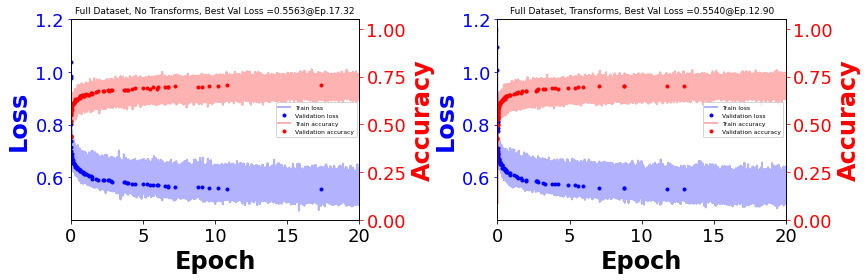

In [9]:
fig = disp_multiple_learn_hist(paths,losslim=None,titles=run_names,leg_font=6, title_font=9, best_only=True)

## Plot Confusion Matrices

In [10]:
test_output = [load_test_output_pn(os.path.join(loc,'test_validation_iteration_dump.npz'),os.path.join(os.getcwd(),'Pointnet_Cut_Indices/pointnet_cut_indices.npz'),np.load(idx_file_paths[i])['test_idxs'], cut_names[i]) 
               for i,loc in enumerate(paths)]

<Figure size 432x288 with 0 Axes>

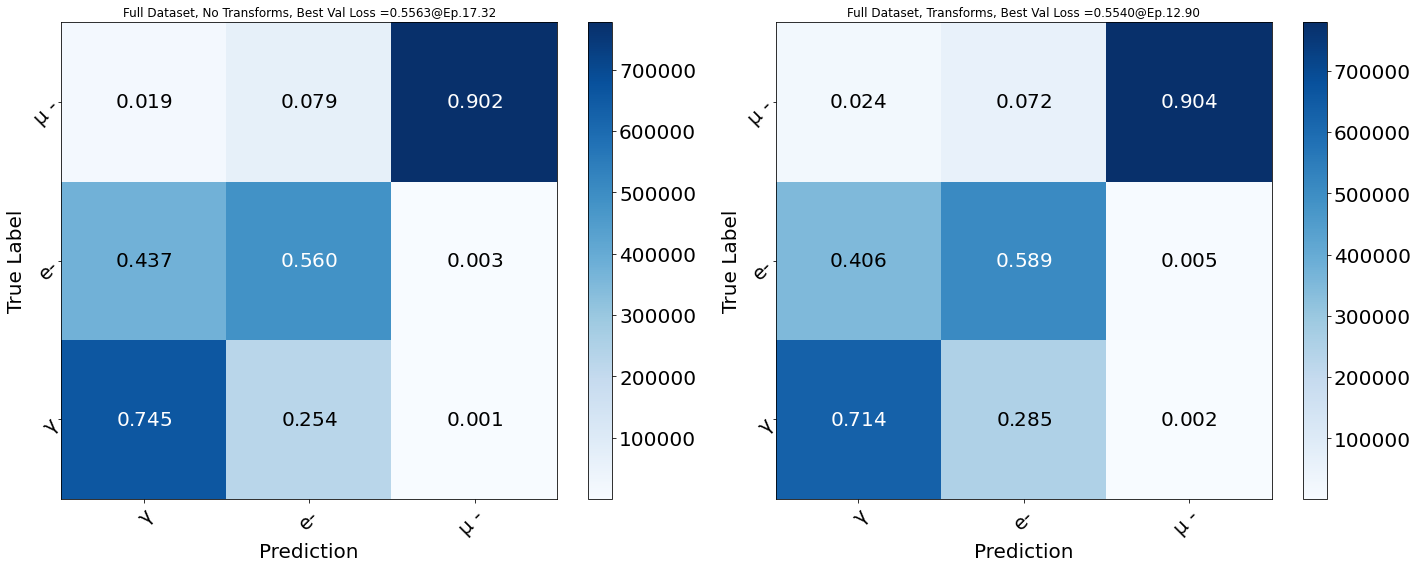

In [11]:
plt.clf()
fig=plot_multiple_confusion_matrix([output['labels'] for output in test_output], [output['predicted_labels'] for output in test_output],
                               ['\u03B3','e-','\u03BC -'],titles=run_names)

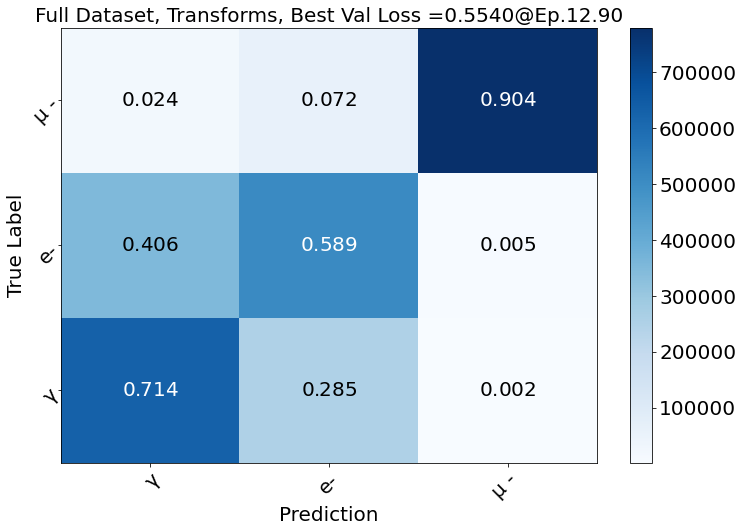

In [12]:
preferred_run=test_output[preferred_run_idx]
plot_confusion_matrix(preferred_run['labels'],preferred_run['predicted_labels'],['\u03B3','e-','\u03BC -'],title=run_names[preferred_run_idx])


In [27]:
print(f"Gamma Events: {np.where(preferred_run['labels']==0)[0].shape[0]} e- Events: {np.where(preferred_run['labels']==1)[0].shape[0]} mu- Events: {np.where(preferred_run['labels']==2)[0].shape[0]}")

Gamma Events: 886037 e- Events: 865453 mu- Events: 861804


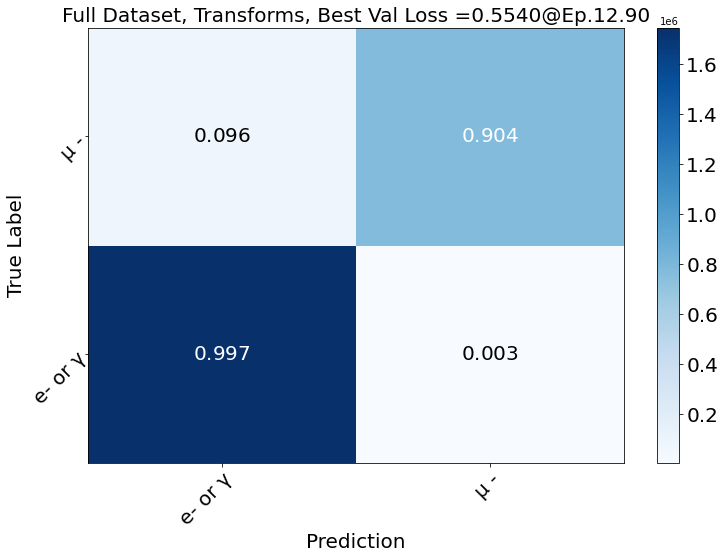

In [13]:
collapsed_sm_1, collapsed_labels_1, collapsed_predictions_1= collapse_test_output(preferred_run['softmax'],
                                                                 preferred_run['labels'],
                                                                 softmax_index_dict,
                                                                 predictions = preferred_run['predicted_labels'])
fig = plot_confusion_matrix(collapsed_labels_1-1,collapsed_predictions_1-1,
                            ['e- or \u03B3','\u03BC -'],title=run_names[preferred_run_idx])

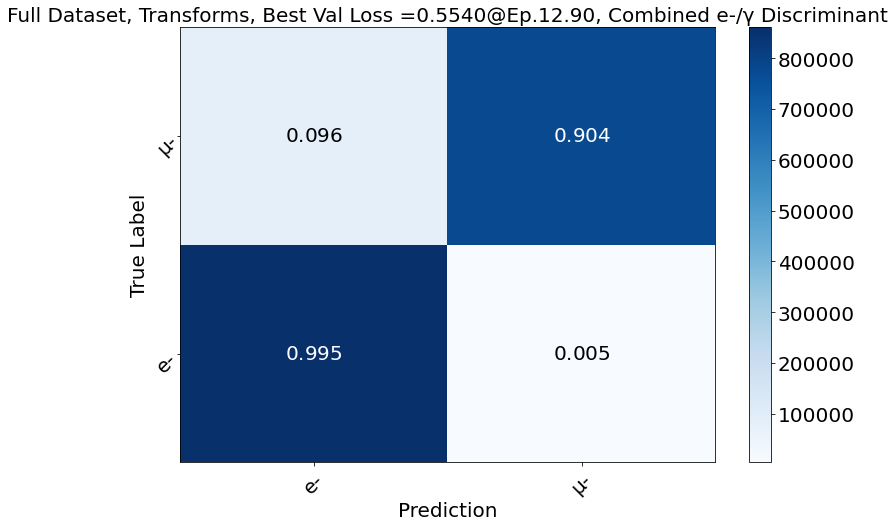

In [14]:
collapsed_sm_1, collapsed_labels_1, collapsed_predictions_1= collapse_test_output(preferred_run['softmax'],
                                                                 preferred_run['labels'],
                                                                 softmax_index_dict,
                                                                 predictions = preferred_run['predicted_labels'])
emu_idxs = np.where(preferred_run['labels']!=0)[0]
fig = plot_confusion_matrix(collapsed_labels_1[emu_idxs]-1,collapsed_predictions_1[emu_idxs]-1,
                            ['e-','\u03BC-'],title=f'{run_names[preferred_run_idx]}, Combined e-/\u03B3 Discriminant')

## ROC Curves

### P(e), e-mu

In [15]:
fprs, tprs, thresholds = zip(*[prep_roc_data(output['softmax'],output['labels'],
                                'rejection',softmax_index_dict,"e","mu",energies=output['energies'],) for output in test_output]
                            )

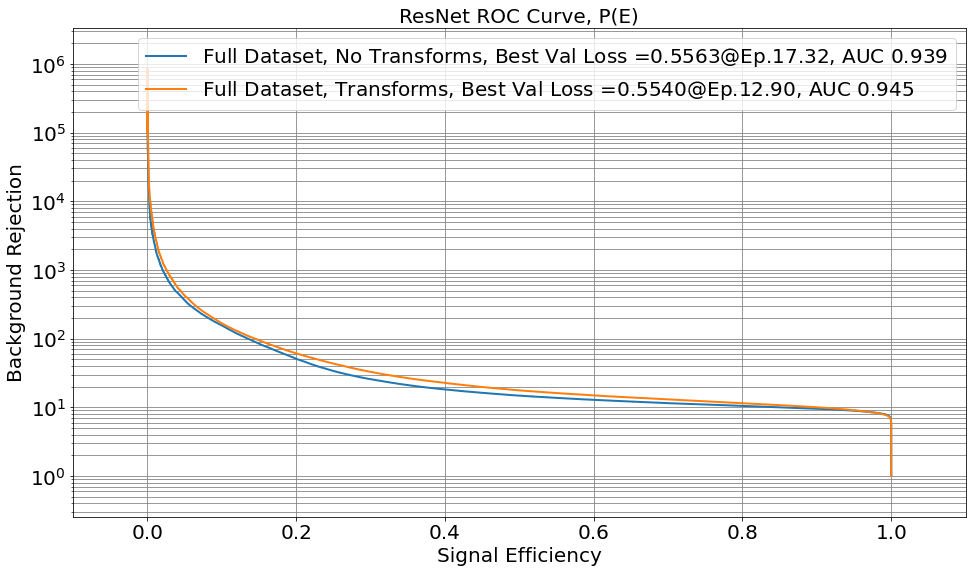

In [16]:
roc_metrics = plot_multiple_ROC((fprs, tprs, thresholds),'rejection', ["e", "mu"], 
                                plot_labels=run_names,
                                png_name = 'overlaid_roc',title='ResNet ROC Curve, P(E)',annotate=False)

### e-gamma

In [17]:
fprs, tprs, thresholds = zip(*[prep_roc_data(output['softmax'],output['labels'],
                                'rejection',softmax_index_dict,"e","gamma",energies=output['energies'],) for output in test_output]
                            )

In [18]:
print(len(fprs))

2


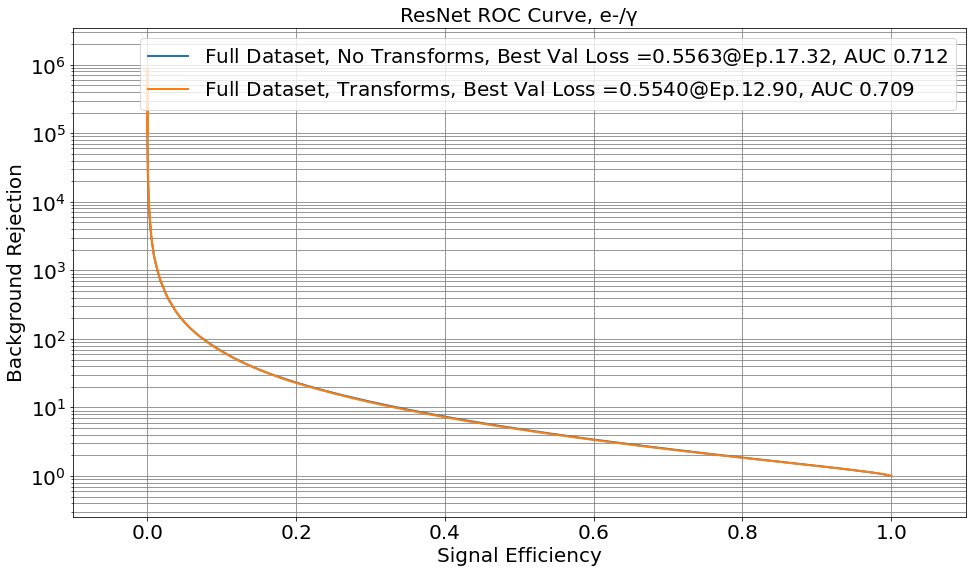

In [19]:
roc_metrics = plot_multiple_ROC((fprs, tprs, thresholds),'rejection', ["e", "gamma"], 
                                plot_labels=run_names,
                                png_name = 'overlaid_roc',title='ResNet ROC Curve, e-/\u03B3',annotate=False)

### P(e) + P(Gamma), e-mu

In [20]:
collapsed_outputs = [collapse_test_output(run['softmax'],
                                                                 run['labels'],
                                                                 softmax_index_dict, ignore_type="gamma") for run in test_output]

fprs, tprs, thresholds = zip(*[prep_roc_data(run[0],run[1],
                                'rejection',softmax_index_dict,"e","mu") for run in collapsed_outputs
                              ]
                            )

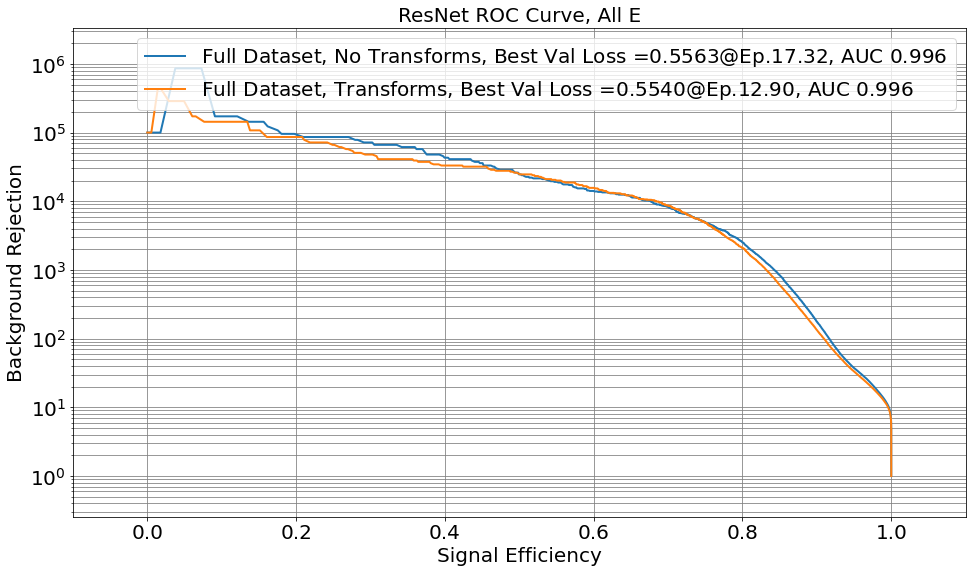

In [21]:
roc_metrics = plot_multiple_ROC((fprs, tprs, thresholds),'rejection', ["e", "mu"], 
                                plot_labels=run_names,
                                png_name = 'overlaid_roc',title='ResNet ROC Curve, All E',annotate=False)

In [33]:
# Load the fiTQun results

# File paths for fiTQun results
fiTQun_e_path = "/fast_scratch/WatChMaL/data/IWCDmPMT_4pi_fulltank_fiTQun_e-.npz"
fiTQun_mu_path = "/fast_scratch/WatChMaL/data/IWCDmPMT_4pi_fulltank_fiTQun_mu-.npz"
fiTQun_gamma_path = "/fast_scratch/WatChMaL/data/IWCDmPMT_4pi_fulltank_fiTQun_gamma.npz"

# Load fiTQun results
f_e = np.load(fiTQun_e_path, allow_pickle=True)
f_mu = np.load(fiTQun_mu_path, allow_pickle=True)
f_gamma = np.load(fiTQun_gamma_path, allow_pickle=True)

fq_filename_original = (f_gamma['filename'],f_e['filename'],f_mu['filename'])
fq_eventids_original = ( f_gamma['eventid'],f_e['eventid'], f_mu['eventid'])
fq_flag_original = (f_gamma['flag'] ,f_e['flag'],f_mu['flag'])
fq_nll_original = (f_gamma['nLL'],f_e['nLL'],f_mu['nLL'])
fq_mom_original = (f_gamma['momentum'],f_e['momentum'],f_mu['momentum'])

n_events = int(reduce(lambda x,y : x+y, list(map(lambda x : x.shape[0],fq_filename_original))))

fq_rootfiles = np.empty(n_events,dtype=object)
fq_eventids = np.zeros(n_events)
fq_flag = np.empty((n_events,2))
fq_nll = np.empty((n_events,2))
fq_mom = np.empty((n_events, 2))

fq_mapping_indices = np.load(os.path.join(npz_path,'fq_mapping_idxs.npz'),allow_pickle=True)['arr_0']

filtered_indices = np.load("/fast_scratch/WatChMaL/data/IWCD_fulltank_300_pe_idxs.npz", allow_pickle=True)
test_filtered_indices = filtered_indices['test_idxs']
f = h5py.File("/data/WatChMaL/data/IWCDmPMT_4pi_fulltank_9M.h5", "r")

original_eventids = np.array(f['event_ids'])
original_rootfiles = np.array(f['root_files'])
filtered_eventids = original_eventids[test_filtered_indices]
filtered_rootfiles = original_rootfiles[test_filtered_indices]
original_labels = np.array(f['labels'])
labels = original_labels[test_filtered_indices]
fq_failed_idxs = np.load(os.path.join(npz_path,'fq_failed_idxs.npz'), allow_pickle = True)['failed_indices_pointing_to_h5_test_set'].astype(int)
slabels = np.delete(labels, fq_failed_idxs)
sfiltered_eventids = np.delete(filtered_eventids, fq_failed_idxs).astype(int)
sfiltered_rootfiles = np.delete(filtered_rootfiles , fq_failed_idxs)

pbar = ProgressBar(widgets=['Arranging FiTQun Data. Progress: ', Percentage(), ' ', Bar(marker='0',left='[',right=']'),
           ' ', ETA()], maxval=n_events)
pbar.start()
for i,ptype in enumerate(slabels):
    fq_rootfiles[i] = str(fq_filename_original[ptype][fq_mapping_indices[i]])
    fq_eventids[i] = fq_eventids_original[ptype][fq_mapping_indices[i]]
    fq_flag[i] = fq_flag_original[ptype][fq_mapping_indices[i]]
    fq_nll[i] = fq_nll_original[ptype][fq_mapping_indices[i]]
    fq_mom[i] = fq_mom_original[ptype][fq_mapping_indices[i]]
    pbar.update(i)
fq_scores = np.zeros((fq_nll.shape[0],3))
fq_scores[:,0] = fq_nll[:,1] - fq_nll[:,0]
fq_scores[:,1] = fq_nll[:,1] - fq_nll[:,0]
fq_scores[:,2] = fq_nll[:,0] - fq_nll[:,1]
fq_labels = slabels
pbar.finish()

pbar = ProgressBar(widgets=['Verification Progress: ', Percentage(), ' ', Bar(marker='0',left='[',right=']'),
           ' ', ETA()], maxval=len(sfiltered_rootfiles))
pbar.start()
for i in range(len(sfiltered_rootfiles)):
    assert re.sub('_fiTQun','',fq_rootfiles[i].split('/')[-1]) == sfiltered_rootfiles[i].split('/')[-1], print(fq_rootfiles[i])
    assert fq_eventids[i] -1 == sfiltered_eventids[i]
    pbar.update(i)
pbar.finish()
assert len(sfiltered_rootfiles) == fq_rootfiles.shape[0]
print("Success! We now have a FiTQun output set in the same order as the h5 test set")

fq_scores_wflagged = fq_scores
fq_labels_wflagged = fq_labels

flagged_idxs = np.load(os.path.join(npz_path, 'fq_flagged_idxs.npz'))['arr_0']
fq_rootfiles = np.delete(fq_rootfiles, flagged_idxs)
fq_eventids = np.delete(fq_eventids, flagged_idxs)
fq_flag = np.delete(fq_flag, flagged_idxs,0)
fq_nll = np.delete(fq_nll, flagged_idxs,0)
fq_scores = np.delete(fq_scores, flagged_idxs,0)
fq_labels = np.delete(fq_labels, flagged_idxs)
fq_mom = np.delete(fq_mom, flagged_idxs, 0)

if fq_dset=='vetoed':
    failed_idxs = np.load(os.path.join(npz_path, 'fq_failed_idxs.npz'))['failed_indices_pointing_to_h5_test_set']
    odveto = np.array(h5py.File('/fast_scratch/WatChMaL/data/IWCDmPMT_4pm_full_tank_ODveto.h5','r')['veto'])
    odveto_mapping_idxs = np.load(os.path.join(os.getcwd(), 'Index_Storage/od_veto_mapping_idxs.npz'))['mapping_idxs_full_set'].astype(int)    
    odveto_mapping_idxs = np.delete(odveto_mapping_idxs, failed_idxs)
    odveto_mapping_idxs = np.delete(odveto_mapping_idxs, flagged_idxs)
    
    odveto=odveto[odveto_mapping_idxs]
    
    assert odveto.shape[0] == fq_rootfiles.shape[0]
    vetoed_idxs = np.where(odveto==1)[0]
    
    fq_rootfiles = np.delete(fq_rootfiles, vetoed_idxs)
    fq_eventids = np.delete(fq_eventids, vetoed_idxs)
    fq_flag = np.delete(fq_flag, vetoed_idxs,0)
    fq_nll = np.delete(fq_nll, vetoed_idxs,0)
    fq_scores = np.delete(fq_scores, vetoed_idxs,0)
    fq_labels = np.delete(fq_labels, vetoed_idxs)
    fq_mom = np.delete(fq_mom, vetoed_idxs, 0)

Arranging FiTQun Data. Progress: 100% [0000000000000000000000000] Time: 0:00:16
Verification Progress: 100% [00000000000000000000000000000000000] Time: 0:00:19


Success! We now have a FiTQun output set in the same order as the h5 test set


/home/cmacdonald/.local/lib/python3.6/site-packages/ipykernel_launcher.py:88: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future


In [38]:
collapsed_sm_1, collapsed_labels_1 = collapse_test_output(preferred_run['softmax'],
                                                                 preferred_run['labels'],
                                                                 softmax_index_dict, ignore_type="gamma")
fprs, tprs, thresholds = zip(*[prep_roc_data(preferred_run['softmax'],preferred_run['labels'],
                                'rejection',softmax_index_dict,"e","mu"),
                                prep_roc_data(collapsed_sm_1,collapsed_labels_1, 'rejection',softmax_index_dict, "e","mu"),
                                prep_roc_data(fq_scores,fq_labels,'rejection',softmax_index_dict,"e","mu")
                              ]
                            )

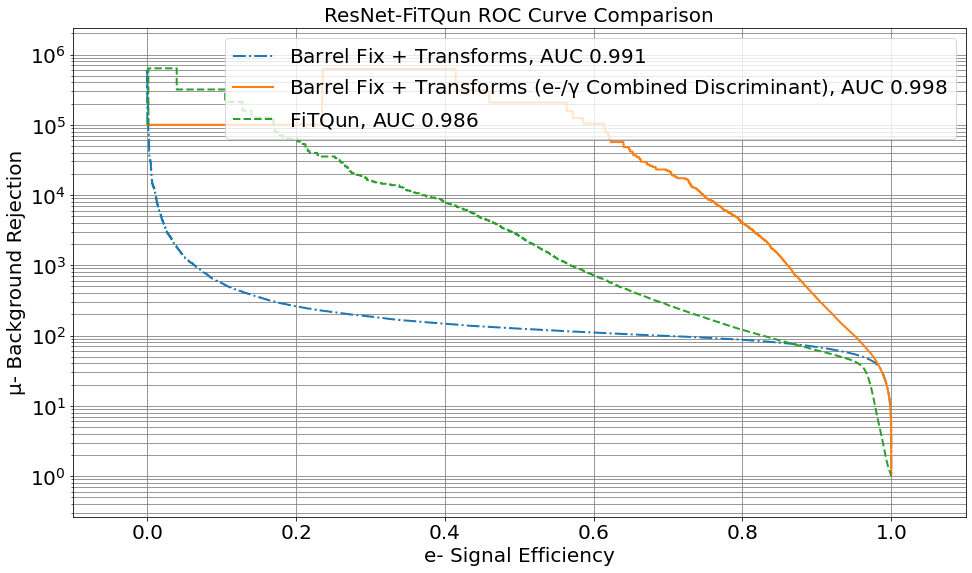

In [39]:
roc_metrics = plot_multiple_ROC((fprs, tprs, thresholds),'rejection', [["e", "mu"],['e','mu'],['e','mu']], 
                                plot_labels = [f'{run_names[preferred_run_idx]}', f'{run_names[preferred_run_idx]} (e-/\u03B3 Combined Discriminant)','FiTQun'],
                                png_name = 'overlaid_roc',title='ResNet-FiTQun ROC Curve Comparison',annotate=False,
                                linestyle=('dashdot','-','--'), xlabel='e- Signal Efficiency',ylabel='\u03BC- Background Rejection')
# plt.savefig(os.path.join(os.getcwd(),'plot_images/ROC_comparison.pdf'))